In [ ]:
# Adversarial attack FGSM and defence with denoising 

## Import required Library

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import math
import cv2 as cv

In [ ]:
!pip install -q torchmetrics
from torchmetrics.classification import MulticlassAccuracy

## device agnostic code

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Build Paper code using ResNet18 and CIFAR10 dataset

## get dataset
in papaer they take cifar10, cifar100, Imagenet but gup contrain i used only cifar10

In [ ]:
train_data = CIFAR10(root = 'data', train = True, transform = ToTensor(), download = True)
test_data = CIFAR10(root = 'data', train = False, transform = ToTensor(), download = True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_data.data[0].shape

(32, 32, 3)

## Make 32 batch size dataloader

In [ ]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
# class name
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [ ]:
image, label = train_data[0]
print(f"image_shape: {image.shape}")

image_shape: torch.Size([3, 32, 32])


Text(0.5, 1.0, 'frog')

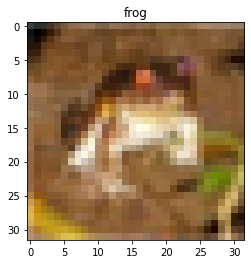

In [ ]:
plt.imshow(image.permute(1,2,0).squeeze())
plt.title(class_names[label])

## fgsm_attack

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
  # Collect the element-wise sign of the data gradient
  sign_data_grad = data_grad.sign()
  # Create the perturbed image by adjusting each pixel of the input image
  perturbed_image = image + epsilon*sign_data_grad
  # Adding clipping to maintain [0,1] range
  perturbed_image = torch.clamp(perturbed_image, 0, 1)
  # Return the perturbed image
  return perturbed_image

## Median Filter

In [ ]:
def median_filter(image):
  n_image = image.cpu()
  np_image = n_image.detach().numpy()
  # print(np_image.shape, type(np_image))
  l = []
  for i in np_image:
    j = cv.medianBlur(i, 3)
    l.append(j)
  med_image = np.asarray(l)
  t_image = torch.from_numpy(med_image)
  return t_image

## Buliding model 
they used resnet18, resnet34, resnet50, resnet154 but limitation of pu i use resnet18

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = self.relu(self.bn1(self.conv1(input)))
        input = self.relu(self.bn2(self.conv2(input)))
        input = input + shortcut
        return self.relu(input)


class CIFAR10ResNet18(nn.Module):
  def __init__(self, in_channels, resblock, outputs):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(512, outputs)

  def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        # print(input.shape)
        input = self.gap(input)
        # print(input.shape)
        input = self.flat(input)
        # print(input.shape)
        input = self.fc(input)

        return input

In [ ]:
resnet18 = CIFAR10ResNet18(3, ResBlock, outputs = 10).to(device)
# summary(resnet18, (3,32,32))
resnet18

CIFAR10ResNet18(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, ep

## Weight initialization

In [ ]:
def _init_weights(m):
  if isinstance(m, nn.Conv2d):
      n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
      m.weight.data.normal_(0, math.sqrt(2. / n))
  elif isinstance(m, nn.BatchNorm2d):
      m.weight.data.fill_(1)
      m.bias.data.zero_()

##Train and Test step

In [ ]:
# train
def train_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
               accuracy_fn, attack: bool, denoise_median: bool, 
               device: torch.device = device):
  
  train_loss, train_acc = 0, 0
  for batch, (x_train, y_train) in enumerate(dataloader):
    
    if device == 'cuda':
      x_train, y_train = x_train.to(device), y_train.to(device)

    x_train.requires_grad = True

    model.train()
    # 1. Forward step
    pred = model(x_train)

    # 2. Loss
    loss = loss_fn(pred, y_train)
    

    # 3. Grad zerostep
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    if attack:
      x_eval = fgsm_attack(x_train, 0.16, x_train.grad.data)
      pred = model(x_eval)

    if denoise_median:
      x_eval = median_filter(x_eval)
      pred = model(x_eval.to(device))

    acc = accuracy_fn(y_train, torch.argmax(pred, dim=1))
    train_loss += loss
    train_acc += acc

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


# test
def test_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, accuracy_fn, 
              device: torch.device = device):
  
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for x_test, y_test in dataloader:

      if device == 'cuda':
        x_test, y_test = x_test.to(device), y_test.to(device)

      # 1. Forward
      test_pred = model(x_test)
      
      # 2. Loss and accuray
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, torch.argmax(test_pred, dim=1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

## Model eval function

In [ ]:
def model_eval(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, accuracy_fn, attack: bool,
              device: torch.device = device):
  eval_loss, eval_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for x_eval, y_eval in dataloader:

      if device == 'cuda':
        x_eval, y_eval = x_eval.to(device), y_eval.to(device)

      
      # 1. Forward
      eval_pred = model(x_eval)
      
      # 2. Loss and accuray
      eval_loss += loss_fn(eval_pred, y_eval)
      eval_acc += accuracy_fn(y_eval, torch.argmax(eval_pred, dim=1))

    eval_loss /= len(dataloader)
    eval_acc /= len(dataloader)

  return eval_loss, eval_acc

##Loss and Acuuray function

In [ ]:
# loss
# loss_fn = nn.KLDivLoss(reduction="batchmean", log_target=True)
loss_fn = nn.CrossEntropyLoss()

# accuray
accuracy_fn = MulticlassAccuracy(num_classes = len(class_names)).to(device)

## train the base model

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)
base_model = CIFAR10ResNet18(3, ResBlock, outputs = 10).to(device)

# initialize weight
base_model.apply(_init_weights)

# optimizer
optimizer = torch.optim.SGD(params = base_model.parameters(), lr = 0.0001)


base_test_accs = []
epoches = 10

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = base_model, dataloader = train_dataloader,
                                     loss_fn = loss_fn, optimizer = optimizer,
                                     accuracy_fn = accuracy_fn, attack = False,
                                     denoise_median = False, device = device)
  
  test_loss, test_acc = test_loop(model = base_model, dataloader = test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  
  base_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Accuray: {test_acc:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  Accuray: 0.2476
Epoch: 2  Accuray: 0.2956
Epoch: 3  Accuray: 0.3287
Epoch: 4  Accuray: 0.3559
Epoch: 5  Accuray: 0.3696
Epoch: 6  Accuray: 0.3808
Epoch: 7  Accuray: 0.4014
Epoch: 8  Accuray: 0.4144
Epoch: 9  Accuray: 0.4238
Epoch: 10  Accuray: 0.4278


## FGSM Attack Model

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)
attack_model = CIFAR10ResNet18(3, ResBlock, outputs = 10).to(device)

# initialize weight
attack_model.apply(_init_weights)

# optimizer
optimizer = torch.optim.SGD(params = attack_model.parameters(), lr = 0.0001)


attack_test_accs = []
epoches = 10

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = attack_model, dataloader = train_dataloader,
                                     loss_fn = loss_fn, optimizer = optimizer,
                                     accuracy_fn = accuracy_fn, attack = True,
                                     denoise_median = False, device = device)
  
  test_loss, test_acc = test_loop(model = attack_model, dataloader = test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  

  attack_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Accuracy: {test_acc:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  Accuracy: 0.1760
Epoch: 2  Accuracy: 0.1929
Epoch: 3  Accuracy: 0.2238
Epoch: 4  Accuracy: 0.2527
Epoch: 5  Accuracy: 0.2506
Epoch: 6  Accuracy: 0.2786
Epoch: 7  Accuracy: 0.2852
Epoch: 8  Accuracy: 0.2767
Epoch: 9  Accuracy: 0.3011
Epoch: 10  Accuracy: 0.3020


## Denoise using Median filter

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)
median_model = CIFAR10ResNet18(3, ResBlock, outputs = 10).to(device)

# initialize weight
median_model.apply(_init_weights)

# optimizer
optimizer = torch.optim.SGD(params = median_model.parameters(), lr = 0.0001)


median_test_accs = []
epoches = 10

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = median_model, dataloader = train_dataloader,
                                     loss_fn = loss_fn, optimizer = optimizer,
                                     accuracy_fn = accuracy_fn, attack = True,
                                     denoise_median = True, device = device)
  
  test_loss, test_acc = test_loop(model = median_model, dataloader = test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  
  median_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Accuracy: {test_acc:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  Accuracy: 0.1934
Epoch: 2  Accuracy: 0.2043
Epoch: 3  Accuracy: 0.2453
Epoch: 4  Accuracy: 0.2746
Epoch: 5  Accuracy: 0.2814
Epoch: 6  Accuracy: 0.2997
Epoch: 7  Accuracy: 0.3136
Epoch: 8  Accuracy: 0.3193
Epoch: 9  Accuracy: 0.3438
Epoch: 10  Accuracy: 0.3345


## Accuray of different model (Base model, Attack model, Denoise model)

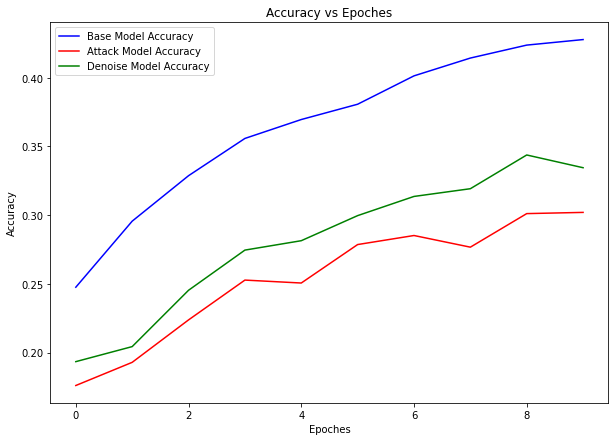

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(range(len(base_test_accs)),base_test_accs, label = "Base Model Accuracy", c = 'b')
plt.plot(range(len(attack_test_accs)),attack_test_accs, label = "Attack Model Accuracy", c = 'r')
plt.plot(range(len(median_test_accs)),median_test_accs, label = "Denoise Model Accuracy", c = 'g')
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoches")
plt.legend()
plt.show()

# Now Try model on Other dataset that not in Paper(MNSIT)

## Get MNIST dataset and make dataloader of it

In [ ]:
train_data = MNIST(root = 'data', train = True, transform = ToTensor(), download = True)
test_data = MNIST(root = 'data', train = False, transform = ToTensor(), download = True)

print(train_data.data[0].shape)

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)

# class name
class_names = train_data.classes
print(class_names)

class_to_idx = train_data.class_to_idx
print(class_to_idx)

torch.Size([28, 28])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


image_shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '5 - five')

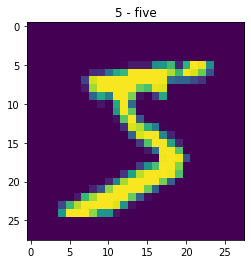

In [ ]:
image, label = train_data[0]
print(f"image_shape: {image.shape}")

plt.imshow(image.permute(1,2,0).squeeze())
plt.title(class_names[label])

## Base Model for MNIST

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)
base_model = CIFAR10ResNet18(1, ResBlock, outputs = 10).to(device)

# initialize weight
base_model.apply(_init_weights)

# optimizer
optimizer = torch.optim.SGD(params = base_model.parameters(), lr = 0.0001)


base_train_losses, base_test_losses = [], []
base_train_accs, base_test_accs = [], []
epoches = 10

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = base_model, dataloader = train_dataloader,
                                     loss_fn = loss_fn, optimizer = optimizer,
                                     accuracy_fn = accuracy_fn, attack = False,
                                     denoise_median = False, device = device)
  
  test_loss, test_acc = test_loop(model = base_model, dataloader = test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  
  base_train_losses.append(train_loss.item())
  base_test_losses.append(test_loss.item())
  base_train_accs.append(train_acc.item())
  base_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Accuray: {test_acc:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  Accuray: 0.8509
Epoch: 2  Accuray: 0.8982
Epoch: 3  Accuray: 0.9171
Epoch: 4  Accuray: 0.9262
Epoch: 5  Accuray: 0.9320
Epoch: 6  Accuray: 0.9348
Epoch: 7  Accuray: 0.9398
Epoch: 8  Accuray: 0.9424
Epoch: 9  Accuray: 0.9444
Epoch: 10  Accuray: 0.9448


## Attack Model for MNIST

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)
attack_model = CIFAR10ResNet18(1, ResBlock, outputs = 10).to(device)

# initialize weight
attack_model.apply(_init_weights)

# optimizer
optimizer = torch.optim.SGD(params = attack_model.parameters(), lr = 0.0001)


attack_test_accs = []
epoches = 10

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = attack_model, dataloader = train_dataloader,
                                     loss_fn = loss_fn, optimizer = optimizer,
                                     accuracy_fn = accuracy_fn, attack = True,
                                     denoise_median = False, device = device)
  
  test_loss, test_acc = test_loop(model = attack_model, dataloader = test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  

  attack_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Accuracy: {test_acc:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  Accuracy: 0.8576
Epoch: 2  Accuracy: 0.9000
Epoch: 3  Accuracy: 0.9152
Epoch: 4  Accuracy: 0.9251
Epoch: 5  Accuracy: 0.9298
Epoch: 6  Accuracy: 0.9358
Epoch: 7  Accuracy: 0.9392
Epoch: 8  Accuracy: 0.9401
Epoch: 9  Accuracy: 0.9432
Epoch: 10  Accuracy: 0.9465


## Denoide Model for MNIST

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)
median_model = CIFAR10ResNet18(1, ResBlock, outputs = 10).to(device)

# initialize weight
median_model.apply(_init_weights)

# optimizer
optimizer = torch.optim.SGD(params = median_model.parameters(), lr = 0.0001)


median_test_accs = []
epoches = 10

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = median_model, dataloader = train_dataloader,
                                     loss_fn = loss_fn, optimizer = optimizer,
                                     accuracy_fn = accuracy_fn, attack = True,
                                     denoise_median = True, device = device)
  
  test_loss, test_acc = test_loop(model = median_model, dataloader = test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  
  median_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Accuracy: {test_acc:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  Accuracy: 0.8502
Epoch: 2  Accuracy: 0.8956
Epoch: 3  Accuracy: 0.9125
Epoch: 4  Accuracy: 0.9215
Epoch: 5  Accuracy: 0.9254


## Accuray of different model (Base model, Attack model, Denoise model) MNIST

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(range(len(base_test_accs)),base_test_accs, label = "Base Model Accuracy", c = 'b')
plt.plot(range(len(attack_test_accs)),attack_test_accs, label = "Attack Model Accuracy", c = 'r')
plt.plot(range(len(median_test_accs)),median_test_accs, label = "Denoise Model Accuracy", c = 'g')
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoches")
plt.legend()
plt.show()